In [1]:
# Import necessary libraries
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt

# Ensure the dataset is loaded
train_df = pd.read_csv("sts_benchmark_dataset_train.csv")
eval_df = pd.read_csv("sts_benchmark_dataset_eval.csv")

train_sample_df = train_df.sample(frac=0.2, random_state=42)
eval_sample_df = eval_df.sample(frac=0.2, random_state=42)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Tokenize data
def tokenize_data(df):
    return tokenizer(
        list(df["input_text"]),
        list(df["aux_text"]),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )

train_encodings = tokenize_data(train_sample_df)
eval_encodings = tokenize_data(eval_sample_df)

# Dataset class for PyTorch
class STSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, scores):
        self.encodings = encodings
        self.scores = list(scores)

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["label"] = torch.tensor(self.scores[idx] / 5.0, dtype=torch.float)
        return item

# Create datasets
train_dataset = STSDataset(train_encodings, train_sample_df["similarity_score"])
eval_dataset = STSDataset(eval_encodings, eval_sample_df["similarity_score"])

print(len(eval_dataset))

Using device: cuda
300


In [2]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
model = model.to("cuda")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def freeze_bert_layers(model, freeze_up_to=0):
    """Freezes layers of the BERT model up to a given index."""
    for name, param in model.bert.named_parameters():
        layer_num = int(name.split('.')[2]) if 'encoder.layer' in name else -1
        if layer_num < freeze_up_to:
            param.requires_grad = False

freeze_bert_layers(model, freeze_up_to=8)

# Print the status of layers
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

bert.embeddings.word_embeddings.weight: Frozen
bert.embeddings.position_embeddings.weight: Frozen
bert.embeddings.token_type_embeddings.weight: Frozen
bert.embeddings.LayerNorm.weight: Frozen
bert.embeddings.LayerNorm.bias: Frozen
bert.encoder.layer.0.attention.self.query.weight: Frozen
bert.encoder.layer.0.attention.self.query.bias: Frozen
bert.encoder.layer.0.attention.self.key.weight: Frozen
bert.encoder.layer.0.attention.self.key.bias: Frozen
bert.encoder.layer.0.attention.self.value.weight: Frozen
bert.encoder.layer.0.attention.self.value.bias: Frozen
bert.encoder.layer.0.attention.output.dense.weight: Frozen
bert.encoder.layer.0.attention.output.dense.bias: Frozen
bert.encoder.layer.0.attention.output.LayerNorm.weight: Frozen
bert.encoder.layer.0.attention.output.LayerNorm.bias: Frozen
bert.encoder.layer.0.intermediate.dense.weight: Frozen
bert.encoder.layer.0.intermediate.dense.bias: Frozen
bert.encoder.layer.0.output.dense.weight: Frozen
bert.encoder.layer.0.output.dense.bias: 

In [4]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from transformers import TrainerCallback


class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.training_losses = []
        self.evaluation_losses = []
        self.epoch = 0

    def on_epoch_end(self, args, state, control, **kwargs):
        # Extract the latest training and evaluation losses from state.log_history
        train_loss = None
        eval_loss = None

        for log in state.log_history:
            if "loss" in log:
                train_loss = log["loss"]
            if "eval_loss" in log:
                eval_loss = log["eval_loss"]

        # Print losses for the current epoch
        print(f"Epoch {self.epoch}:")
        if train_loss is not None:
            print(f"  Training Loss: {train_loss:.4f}")
        if eval_loss is not None:
            print(f"  Evaluation Loss: {eval_loss:.4f}")

        self.epoch += 1

    def on_train_end(self, args, state, control, **kwargs):
        """
        This method is triggered at the end of training and prints a summary of losses.
        """
        print("\nTraining Complete!")
        print("Final Losses Per Epoch:")
        for epoch, (train_loss, eval_loss) in enumerate(
            zip(self.training_losses, self.evaluation_losses), start=1
        ):
            print(f"  Epoch {epoch}: Training Loss = {train_loss}, Evaluation Loss = {eval_loss}")


training_args = TrainingArguments(
    output_dir="./results_sampled",         
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,                      
    per_device_train_batch_size=16,          
    per_device_eval_batch_size=16,            
    num_train_epochs=10,                    
    weight_decay=0.001,                       
    save_total_limit=3,                       
    report_to="none",              
    lr_scheduler_type="cosine",
    load_best_model_at_end=True,

)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    callbacks=[LossLoggerCallback()],

)

# Train the model
print("Starting training...")
train_output = trainer.train()

# Evaluate the model
print("Evaluating on the validation set...")
results = trainer.evaluate(eval_dataset)
print("Validation Results:", results)

# Save the fine-tuned model and tokenizer
model.save_pretrained("./fine_tuned_bert_sts")
tokenizer.save_pretrained("./fine_tuned_bert_sts")
print("Model and tokenizer saved!")

# Extract training logs for plotting
# train_logs = train_output.metrics
# eval_logs = trainer.evaluate(eval_dataset)


Starting training...


  0%|          | 0/720 [00:00<?, ?it/s]

Epoch 0:
{'loss': 0.1108, 'grad_norm': 1.7790671586990356, 'learning_rate': 1.9510565162951538e-05, 'epoch': 1.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.02828211709856987, 'eval_runtime': 0.8427, 'eval_samples_per_second': 355.983, 'eval_steps_per_second': 22.546, 'epoch': 1.0}
Epoch 1:
  Training Loss: 0.1108
  Evaluation Loss: 0.0283
{'loss': 0.0525, 'grad_norm': 3.282228946685791, 'learning_rate': 1.8090169943749477e-05, 'epoch': 2.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.03189115226268768, 'eval_runtime': 0.8136, 'eval_samples_per_second': 368.723, 'eval_steps_per_second': 23.352, 'epoch': 2.0}
Epoch 2:
  Training Loss: 0.0525
  Evaluation Loss: 0.0319
{'loss': 0.0393, 'grad_norm': 2.526024580001831, 'learning_rate': 1.5877852522924733e-05, 'epoch': 3.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.028185253962874413, 'eval_runtime': 0.8146, 'eval_samples_per_second': 368.271, 'eval_steps_per_second': 23.324, 'epoch': 3.0}
Epoch 3:
  Training Loss: 0.0393
  Evaluation Loss: 0.0282
{'loss': 0.035, 'grad_norm': 0.9903405904769897, 'learning_rate': 1.3090169943749475e-05, 'epoch': 4.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.02807765267789364, 'eval_runtime': 0.8584, 'eval_samples_per_second': 349.501, 'eval_steps_per_second': 22.135, 'epoch': 4.0}
Epoch 4:
  Training Loss: 0.0350
  Evaluation Loss: 0.0281
{'loss': 0.0298, 'grad_norm': 1.4594242572784424, 'learning_rate': 1e-05, 'epoch': 5.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.03016560897231102, 'eval_runtime': 0.8265, 'eval_samples_per_second': 362.957, 'eval_steps_per_second': 22.987, 'epoch': 5.0}
Epoch 5:
  Training Loss: 0.0298
  Evaluation Loss: 0.0302
{'loss': 0.0267, 'grad_norm': 1.3151830434799194, 'learning_rate': 6.909830056250527e-06, 'epoch': 6.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.02840052917599678, 'eval_runtime': 0.8204, 'eval_samples_per_second': 365.696, 'eval_steps_per_second': 23.161, 'epoch': 6.0}
Epoch 6:
  Training Loss: 0.0267
  Evaluation Loss: 0.0284
{'loss': 0.0238, 'grad_norm': 1.0338585376739502, 'learning_rate': 4.12214747707527e-06, 'epoch': 7.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.031028158962726593, 'eval_runtime': 0.8242, 'eval_samples_per_second': 363.997, 'eval_steps_per_second': 23.053, 'epoch': 7.0}
Epoch 7:
  Training Loss: 0.0238
  Evaluation Loss: 0.0310
{'loss': 0.0237, 'grad_norm': 0.8528518676757812, 'learning_rate': 1.9098300562505266e-06, 'epoch': 8.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.02898724190890789, 'eval_runtime': 0.8252, 'eval_samples_per_second': 363.554, 'eval_steps_per_second': 23.025, 'epoch': 8.0}
Epoch 8:
  Training Loss: 0.0237
  Evaluation Loss: 0.0290
{'loss': 0.0221, 'grad_norm': 1.028995156288147, 'learning_rate': 4.894348370484648e-07, 'epoch': 9.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.029510319232940674, 'eval_runtime': 0.8303, 'eval_samples_per_second': 361.323, 'eval_steps_per_second': 22.884, 'epoch': 9.0}
Epoch 9:
  Training Loss: 0.0221
  Evaluation Loss: 0.0295
{'loss': 0.0219, 'grad_norm': 1.4944701194763184, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.029339641332626343, 'eval_runtime': 0.8945, 'eval_samples_per_second': 335.366, 'eval_steps_per_second': 21.24, 'epoch': 10.0}
{'train_runtime': 101.3709, 'train_samples_per_second': 113.445, 'train_steps_per_second': 7.103, 'train_loss': 0.03856019344594744, 'epoch': 10.0}

Training Complete!
Final Losses Per Epoch:
Evaluating on the validation set...


  0%|          | 0/19 [00:00<?, ?it/s]

Validation Results: {'eval_loss': 0.02807765267789364, 'eval_runtime': 0.962, 'eval_samples_per_second': 311.838, 'eval_steps_per_second': 19.75, 'epoch': 10.0}
Model and tokenizer saved!


[{'loss': 0.1108, 'grad_norm': 1.7790671586990356, 'learning_rate': 1.9510565162951538e-05, 'epoch': 1.0, 'step': 72}, {'loss': 0.0525, 'grad_norm': 3.282228946685791, 'learning_rate': 1.8090169943749477e-05, 'epoch': 2.0, 'step': 144}, {'loss': 0.0393, 'grad_norm': 2.526024580001831, 'learning_rate': 1.5877852522924733e-05, 'epoch': 3.0, 'step': 216}, {'loss': 0.035, 'grad_norm': 0.9903405904769897, 'learning_rate': 1.3090169943749475e-05, 'epoch': 4.0, 'step': 288}, {'loss': 0.0298, 'grad_norm': 1.4594242572784424, 'learning_rate': 1e-05, 'epoch': 5.0, 'step': 360}, {'loss': 0.0267, 'grad_norm': 1.3151830434799194, 'learning_rate': 6.909830056250527e-06, 'epoch': 6.0, 'step': 432}, {'loss': 0.0238, 'grad_norm': 1.0338585376739502, 'learning_rate': 4.12214747707527e-06, 'epoch': 7.0, 'step': 504}, {'loss': 0.0237, 'grad_norm': 0.8528518676757812, 'learning_rate': 1.9098300562505266e-06, 'epoch': 8.0, 'step': 576}, {'loss': 0.0221, 'grad_norm': 1.028995156288147, 'learning_rate': 4.894

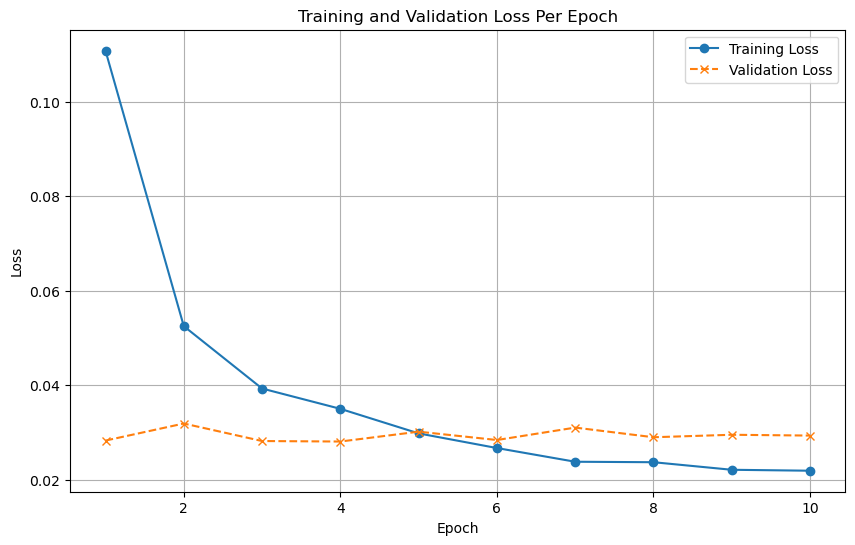

In [5]:
# Extract logs for training and validation
train_logs = [log for log in trainer.state.log_history if 'loss' in log]
eval_logs = [log for log in trainer.state.log_history if 'eval_loss' in log]

print(train_logs)

# Group training loss by epoch
train_loss_per_epoch = {}
for log in train_logs:
    epoch = int(log['epoch'])
    if epoch not in train_loss_per_epoch:
        train_loss_per_epoch[epoch] = []
    train_loss_per_epoch[epoch].append(log['loss'])

# Calculate the average training loss for each epoch
train_loss = [sum(losses) / len(losses) for epoch, losses in sorted(train_loss_per_epoch.items())]

# Extract unique validation losses (one per epoch)
eval_loss_per_epoch = {}
for log in eval_logs:
    epoch = int(log['epoch'])
    if epoch not in eval_loss_per_epoch:
        eval_loss_per_epoch[epoch] = log['eval_loss']

eval_loss = [loss for _, loss in sorted(eval_loss_per_epoch.items())]

# Align epochs
epochs = range(1, max(len(train_loss), len(eval_loss)) + 1)

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_loss)], train_loss, label="Training Loss", marker='o', linestyle='-')
plt.plot(epochs[:len(eval_loss)], eval_loss, label="Validation Loss", marker='x', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Per Epoch")
plt.legend()
plt.grid()
plt.show()


In [6]:
# Import the necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr


# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert_sts")
tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert_sts")
model.eval()

# Load STS-B evaluation dataset (validation or test split)
stsb_data = load_dataset("glue", "stsb", split="validation")  # Use "test" for the test set

# print(stsb_data[0])

# Function to compute predictions
def compute_predictions(dataset):
    predictions = []
    ground_truths = []

    for example in dataset:
        sentence1 = example["sentence1"]
        sentence2 = example["sentence2"]
        true_score = example["label"]

        inputs = tokenizer(sentence1, sentence2, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            logits = model(**inputs).logits
            # print(logits)
            predicted_score = logits.squeeze().item()

        predictions.append(predicted_score)
        ground_truths.append(true_score)

    return predictions, ground_truths

# Compute predictions and ground truths
predicted_scores, true_scores = compute_predictions(stsb_data)

# Compute Pearson and Spearman correlations
pearson_corr = pearsonr(predicted_scores, true_scores)
spearman_corr = spearmanr(predicted_scores, true_scores)

print(f"Pearson Correlation: {pearson_corr[0]:.4f}")
print(f"Spearman Correlation: {spearman_corr.correlation:.4f}")


Pearson Correlation: 0.8160
Spearman Correlation: 0.8159


In [7]:
# Import the necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr


# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased" , num_labels=1)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()

# Load STS-B evaluation dataset (validation or test split)
stsb_data = load_dataset("glue", "stsb", split="validation")  # Use "test" for the test set

# print(stsb_data[0])

# Function to compute predictions
def compute_predictions(dataset):
    predictions = []
    ground_truths = []

    for example in dataset:
        sentence1 = example["sentence1"]
        sentence2 = example["sentence2"]
        true_score = example["label"]

        inputs = tokenizer(sentence1, sentence2, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            logits = model(**inputs).logits
            # print(logits)
            predicted_score = logits.squeeze().item()

        predictions.append(predicted_score)
        ground_truths.append(true_score)

    return predictions, ground_truths

# Compute predictions and ground truths
predicted_scores, true_scores = compute_predictions(stsb_data)

# Compute Pearson and Spearman correlations
pearson_corr = pearsonr(predicted_scores, true_scores)
spearman_corr = spearmanr(predicted_scores, true_scores)

print(f"Pearson Correlation: {pearson_corr[0]:.4f}")
print(f"Spearman Correlation: {spearman_corr.correlation:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pearson Correlation: -0.4612
Spearman Correlation: -0.6321


In [8]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert_sts", output_attentions=True)
tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert_sts")

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


sentence1 = "The chef prepared a delicious meal."
sentence2 = "A cook made a tasty dish."

inputs = tokenizer(sentence1, sentence2, return_tensors="pt", padding=True, truncation=True, max_length=128)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Forward pass with attention outputs
outputs = model(**inputs, output_attentions=True)

# Extract attention weights
attention_weights = outputs.attentions  # List of tensors [num_layers, batch_size, num_heads, seq_len, seq_len]

# print(attention_weights)


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


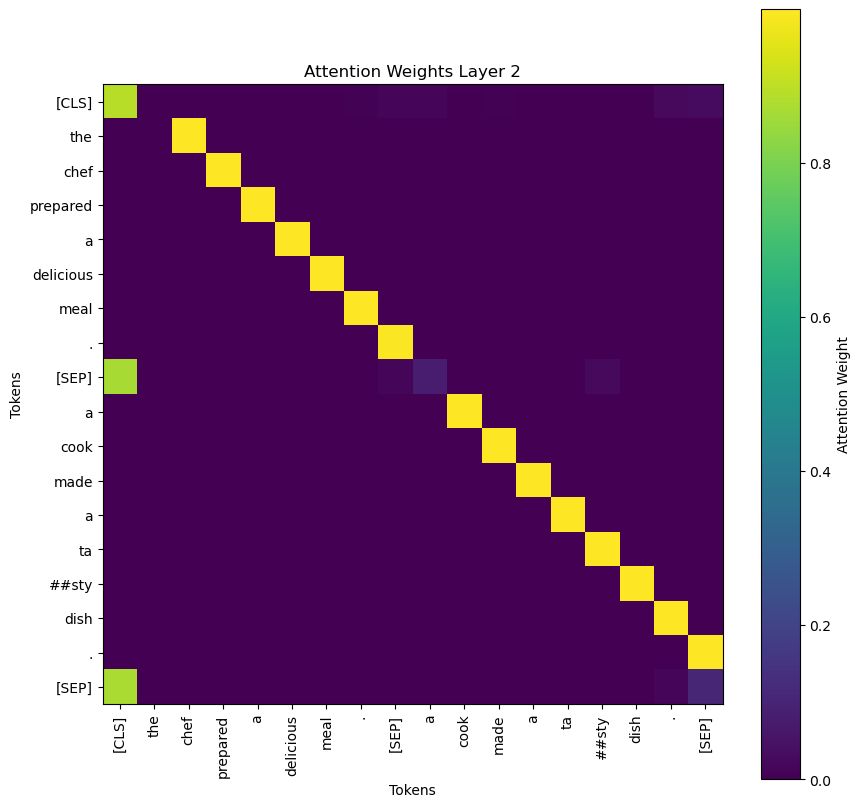

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Select attention weights from the first layer and the first head
layer = 2 # First layer (index starts at 0)
head = 0   # First head

# Extract the attention matrix for the chosen layer and head
attention_matrix = attention_weights[layer][0, head].detach().cpu().numpy()  # Shape: [seq_len, seq_len]

# Get tokenized input tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

def plot_attention_matrix(attention_matrix, tokens):
    plt.figure(figsize=(10, 10))
    plt.imshow(attention_matrix, cmap="viridis")
    plt.colorbar(label="Attention Weight")
    plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=90)
    plt.yticks(ticks=np.arange(len(tokens)), labels=tokens)
    plt.title(f"Attention Weights Layer {layer}")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.show()

plot_attention_matrix(attention_matrix, tokens)



In [12]:
from transformers import BertTokenizer, BertModel

# Load the fine-tuned model and tokenizer
model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

sentence1 = "The chef prepared a delicious meal."
sentence2 = "A cook made a tasty dish."

# Tokenize each sentence individually
inputs1 = tokenizer(sentence1, return_tensors="pt", padding=True, truncation=True, max_length=128)
inputs2 = tokenizer(sentence2, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Move inputs to device
inputs1 = {key: val.to(device) for key, val in inputs1.items()}
inputs2 = {key: val.to(device) for key, val in inputs2.items()}

# Forward pass for each sentence
with torch.no_grad():
    outputs1 = model(**inputs1)
    outputs2 = model(**inputs2)

# print(outputs1)

# Extract `[CLS]` embeddings
cls_embedding1 = outputs1.last_hidden_state[0, 0]  # `[CLS]` for sentence 1
cls_embedding2 = outputs2.last_hidden_state[0, 0]  # `[CLS]` for sentence 2

# print(cls_embedding2)

import torch.nn.functional as F

# Compute cosine similarity
cosine_similarity = F.cosine_similarity(cls_embedding1, cls_embedding2, dim=0).item()
print(f"Cosine Similarity: {cosine_similarity}")


Cosine Similarity: 0.8595818877220154


In [13]:
from sklearn.decomposition import PCA
import plotly.express as px


# Stack embeddings and reduce to 3D
embeddings = torch.stack([cls_embedding1.squeeze(0), cls_embedding2.squeeze(0)]).cpu().numpy()
print(embeddings.shape)

# Reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Prepare data for visualization
data = {
    "PC1": reduced_embeddings[:, 0],
    "PC2": reduced_embeddings[:, 1],
    "Sentence": ["Sentence 1", "Sentence 2"]
}

# Create 2D scatter plot with Plotly
fig = px.scatter(
    data,
    x="PC1",
    y="PC2",
    color="Sentence",
    title="2D Visualization of Latent Representations",
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"}
)

fig.update_traces(marker=dict(size=10, line=dict(width=2, color="DarkSlateGrey")))
fig.update_layout(scene=dict(xaxis_title="PC1", yaxis_title="PC2"))
fig.show()



(2, 768)


In [16]:
from sklearn.manifold import TSNE

# Add a third sentence
sentence3 = "A person strums a guitar melodically."
inputs3 = tokenizer(sentence3, return_tensors="pt", truncation=True, padding=True, max_length=128)
inputs3 = {key: val.to(device) for key, val in inputs3.items()}

# Forward pass for the third sentence
with torch.no_grad():
    outputs3 = model(**inputs3)

# print(outputs3)

# Extract `[CLS]` embedding for the third sentence
cls_embedding3 = outputs3.last_hidden_state[0, 0]  # Shape: [1, hidden_dim]

# Stack embeddings (now 3 samples)
embeddings = torch.stack([
    cls_embedding1.squeeze(0),
    cls_embedding2.squeeze(0),
    cls_embedding3.squeeze(0)
]).cpu().numpy()

# Reduce dimensionality to 3D
tsne = TSNE(n_components=3, perplexity=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Prepare data for visualization
data = {
    "PC1": reduced_embeddings[:, 0],
    "PC2": reduced_embeddings[:, 1],
    "PC3": reduced_embeddings[:, 2],
    "Sentence": ["Sentence 1", "Sentence 2", "Sentence 3"]
}

# Create 3D scatter plot with Plotly
fig = px.scatter_3d(
    data,
    x="PC1",
    y="PC2",
    z="PC3",
    color="Sentence",
    title="3D Visualization of Latent Representations",
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2", "PC3": "Principal Component 3"}
)

fig.update_traces(marker=dict(size=10, line=dict(width=2, color="DarkSlateGrey")))
fig.update_layout(scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"))
fig.show()


In [17]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the fine-tuned model and tokenizer
model_path = "./fine_tuned_bert_sts"  # Path to your fine-tuned model
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)  # Ensure the correct model type
model.eval()

# Function to compute similarity score
def compute_similarity(text1, text2):
    # Tokenize the input sentences
    inputs = tokenizer(text1, text2, return_tensors="pt", padding=True, truncation=True)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Handle logits for regression or classification
    if outputs.logits.shape[-1] == 1:  # Regression model
        similarity_score = outputs.logits.squeeze().item()  # Squeeze to get a scalar value
    elif outputs.logits.shape[-1] > 1:  # Classification model
        probabilities = torch.softmax(outputs.logits, dim=-1)  # Compute probabilities
        similarity_score = probabilities[0, 1].item()  # Use the probability of the "similar" class
    else:
        raise ValueError("Unexpected model output shape.")
    
    return similarity_score

# Define example data
student_texts = [
    "Machine learning is a subfield of artificial intelligence.",
    "Deep learning is a type of machine learning that uses neural networks.",
    "Neural networks are inspired by the structure of the human brain.",
]

reference_texts = [
    "Artificial intelligence includes machine learning and deep learning.",
    "Neural networks mimic the human brain's structure and function.",
    "Machine learning uses data and algorithms to learn patterns.",
]

# Threshold for potential plagiarism
similarity_threshold = 3.5 / 5  # Adjust based on experimentation

# Check for plagiarism
for i, student_text in enumerate(student_texts):
    print(f"\nStudent Text {i + 1}: {student_text}")
    for j, reference_text in enumerate(reference_texts):
        similarity = compute_similarity(student_text, reference_text)
        status = "Potential Plagiarism" if similarity >= similarity_threshold else "Not Plagiarized"
        print(f"  Reference {j + 1}: {reference_text}")
        print(f"    Similarity Score: {similarity:.2f} -> {status}")



Student Text 1: Machine learning is a subfield of artificial intelligence.
  Reference 1: Artificial intelligence includes machine learning and deep learning.
    Similarity Score: 0.72 -> Potential Plagiarism
  Reference 2: Neural networks mimic the human brain's structure and function.
    Similarity Score: 0.25 -> Not Plagiarized
  Reference 3: Machine learning uses data and algorithms to learn patterns.
    Similarity Score: 0.52 -> Not Plagiarized

Student Text 2: Deep learning is a type of machine learning that uses neural networks.
  Reference 1: Artificial intelligence includes machine learning and deep learning.
    Similarity Score: 0.60 -> Not Plagiarized
  Reference 2: Neural networks mimic the human brain's structure and function.
    Similarity Score: 0.49 -> Not Plagiarized
  Reference 3: Machine learning uses data and algorithms to learn patterns.
    Similarity Score: 0.51 -> Not Plagiarized

Student Text 3: Neural networks are inspired by the structure of the human b